# Desenvolvendo um teste A/B com base no *dataset* do *Kagle: https://www.kaggle.com/datasets/zhangluyuan/ab-testing?select=ab_data.csv

#### Um dos objetivos da aplicação do teste A/B é permitir a avaliação de uma mudança em relação ao seu estado anterior, como é o caso deste *dataset*, responsável por avaliar se a mudança no *design* de um site resulta, estatisticamente, em maior taxa de conversão de clientes (variável dependente). Para a implementação desse método, a amostra de dados do site devem ser separadas em dois grupos: I) um grupo de controle (*design* antigo); II) grupo de tratamento (*design* novo); sendo as variáveis independentes da análise realizada a seguir. De outro modo, a ideia desses dois grupos é que os resultados possam ser comparados e, assim, indicar se realmente houve variações estatisticamente significativas devido às modificações de *design* realizadas na organização.

#### Como nesse *dataset* lida-se com taxas de conversões, ou seja, compras realizadas pelos clientes em suas visitas ao site da organização, existem duas possibilidades: I) o consumidor acessa o site, mas não compra o produto ofertado; II) o consumidor acessa o site e compra o produto ofertado. Assim, é possível trabalhar com variáveis dummies: 0 e 1, respectivamente, permitindo o cálculo das médias de conversões e não conversões a partir da quantidade de acesso. Para realizar os diferentes cálculos necessários para o teste a/b neste *dataset*, as bibliotecas abaixo são necessárias para a realização do exercício.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.stats.api as sms
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from math import ceil


#### O gestor da organização Xyz apresenta um problema de negócio para sua equipe de dados: **Precisa saber se os novos investimentos na estruturação do *design* podem resultar em aumento da taxa de conversão para a organização?** Com essa problemática em pauta, e sabendo que a taxa de conversão atual está por volta de 11%, com o objetivo estratégico de aumentar em 3 pontos percentuais (14%), como o teste a/b deverá ser realizado? O primeiro passo é calcular o tamanho da amostra ideal para a realização do teste.

In [2]:
# calculando o tamanho da amostra

tamanho_efeito = sms.proportion_effectsize(0.11, 0.14)

tamanho_n = sms.NormalIndPower().solve_power(
    tamanho_efeito,
    power= 0.8,
    alpha= 0.05,
    ratio= 1
)

tamanho_n = ceil(tamanho_n)
print(tamanho_n)

1902


#### Primeiramente foi definido o tamanho do efeito, a partir dos dados repassados pelo gestor da organização. Na sequência, é trabalhado o tamanho da amostra necessária para a realização do teste, o *power* indica o poder do teste, ou seja, a probabilidade de encontrar diferença estatística entre o grupo de análise (antigo x novo site), quando a diferença de fato está presente (encontrar o verdadeiro positivo), utilizando como padrão 0.8. Já o *alpha* indica o valor crítico, quanto menor, mais rígido é o modelo (0.01). Dentro desse contexto, o tamanno ideal da amostra é de 1902.

#### O resultado acima apresenta o tamanho da amostra necessário para realizar o teste a/b com segurança estatística para cada um dos dois grupos objetos de análises mencionados anteriormente.  Definir o tamanho da amostra ideal é uma importante prática nas organizações porque evita que recursos financeiros escassos sejam dispendidos em coleta de amostras acima das realmente necessária. Assim, abaixo é necessário importar os dados do *dataset* do  *Kaggle* *A/B testing* para analisar se existem a quantidade de dados suficientes para essa análise e realizar os demais tratamentos necessários antes da aplicação do teste a/b.

In [3]:
conversao = pd.read_csv('ab_data.csv')
conversao

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


#### Neste *dataset* existem 294478 linhas (observações), considerando o somatório entre o grupo de controle (*control*) e tratamento (*treatment*), com a coluna de conversão (*converted*) indicando quando os usuários que visitam a página nova ou antiga acabam também comprando (1) o produto ofertado pela organização. Mais informações sobre a estrutura dos dados podem ser realizadas pelo *Pandas*, como os dois códigos abaixo.

In [4]:
conversao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [5]:
conversao.columns

Index(['user_id', 'timestamp', 'group', 'landing_page', 'converted'], dtype='object')

#### Desse modo, não existem vetores com linhas (áreas) perdidos, ou seja, *missing values*, o que poderia ser um problema para a análise de dados, necessitando de correção desses dados perdidos. Também, as informações provenientes do código aponta a existência de três colunas do tipo objeto e duas do tipo inteiro, já direcionando para o próximo código, responsável por apresentar o nome dos cinco vetores existentes nesse *dataset*. Por fim, o procedimento realizado abaixo é feito para existir a certeza de que todo o grupo de controle (tratamento) está vendo a página antiga (página nova). 

In [6]:
pd.crosstab(conversao['group'], conversao['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [7]:
contagem = conversao['user_id'].value_counts(ascending=False)
usuario_multiplo = contagem[contagem > 1].count()
print(f'Existem {usuario_multiplo} usuários que aparecem em mais de um momento na base de dados.')

Existem 3894 usuários que aparecem em mais de um momento na base de dados.


In [8]:
drop_usuario = contagem[contagem > 1].index
conversao = conversao[~conversao['user_id'].isin(drop_usuario)]
print(f'A retirada das contagens repetidas de usuários múltiplos resultou em uma nova base com {conversao.shape[0]} linhas.')

A retirada das contagens repetidas de usuários múltiplos resultou em uma nova base com 286690 linhas.


#### Os procedimentos realizados acima fazem parte do tratamento da base de dados para retirar usuários que tenham contagens múltiplias, ou seja, usúarios duplicados dentro da base de dados. Esse processo é fundamental para que a realização do teste a/b ocorra da maneira correta, sem contabilizar em um ou ambos os grupos de análises, evitando que os resultados dessa análise sejam enviesados pela utlização de um mesmo usuário duas ou mais vezes. Como resultado desse processo, a base de dados foi reduzida em 3894 usuários, de um total de 294478, que apareciam mais de uma vez na base de dados original e resultando em uma nova base com 286690 usuários.
#### Desse modo, mesmo com a perda de alguns dados decorrentes da existência dos usuários múltiplos, não existem problemas maiores para a realização do teste a/b. Isso porque são necessário para a implementação deste método estatístico 2428 usuários para cada grupo analisado.

## A/B Teste

#### Após a análise exploratória da estrutura de dados e posterior tratamento sobre usuários múltiplos, seguem alguns elementos importantes para os procedimentos a seguir:
#### n = 1902 (para cada grupo)
#### grupos = controle e tratamento
#### dummy = 1 -> comprou; 0 -> não comprou
#### Objetivo: o novo site deve aumentar em 3 pontos percentuais as conversões de vendas (9% para 12%)

#### Abaixo são definidas as duas amostras aleatórios de 1902 usuários para o grupo de controle e tratamento. Vale destacar que a utilização do código *random_state* tem como função tornar o exercício atual replicável, captando as mesmas amostras utilizados no momento de realização deste teste.

In [9]:
controle = conversao[conversao['group'] == 'control'].sample(n= tamanho_n, random_state= 11)
tratamento = conversao[conversao['group'] == 'treatment'].sample(n= tamanho_n, random_state= 11)

abteste = pd.concat([controle, tratamento], axis= 0)
abteste.reset_index(drop= True, inplace= True)
abteste


,user_id,timestamp,group,landing_page,converted
0,794160,2017-01-18 02:31:09.881857,control,old_page,0
1,849290,2017-01-23 04:38:48.998161,control,old_page,0
2,767762,2017-01-18 13:18:18.881612,control,old_page,0
3,666491,2017-01-23 04:22:39.789417,control,old_page,0
4,795331,2017-01-05 02:28:31.324120,control,old_page,0
...,...,...,...,...,...
3799,633467,2017-01-10 20:33:08.014702,treatment,new_page,0
3800,747337,2017-01-17 20:37:30.287625,treatment,new_page,0
3801,936598,2017-01-06 12:12:11.262905,treatment,new_page,0
3802,764348,2017-01-07 17:07:28.234161,treatment,new_page,0


#### Com o código acima é possível observar que ocorreu a separação entre o grupo controle (*control*) e tratamento (*treatment*), cada um com 1902 usuários. Abaixo são realizados dois códigos para obter mais resultados sobre a dinâmicas provenientes do teste a/b realizado (info) e a contagem de cada grupo (value_counts).

In [10]:
abteste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3804 entries, 0 to 3803
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       3804 non-null   int64 
 1   timestamp     3804 non-null   object
 2   group         3804 non-null   object
 3   landing_page  3804 non-null   object
 4   converted     3804 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 148.7+ KB


In [11]:
abteste['group'].value_counts()

control      1902
treatment    1902
Name: group, dtype: int64

#### Os resultados desses dois útlimos códigos comprovam que os resultados continuam sem *missing values* e com os 3804 usuários necessários para o procedimento do teste a/b para a definição de que se a mudança de *design* com o objetivo de elevar as conversões em 3 pontos percentuais para cima são estatisticamente significativas. Com a confirmação da base de dados corretas, a seguir é possível começar a realizar as primeiras estatísticas sobre a amostra de dados dividida nos dois grupos.

In [12]:
taxa_conversao = abteste.groupby('group')['converted']
std_p = lambda x: np.std(x, ddof= 0)
se_p = lambda x: stats.sem(x, ddof= 0)

taxa_conversao = taxa_conversao.agg([np.mean, std_p, se_p])
taxa_conversao.columns = ['taxa_conversao', 'desvio_padrao', 'erro_padrao']

taxa_conversao.style.format('{:.3f}')


,taxa_conversao,desvio_padrao,erro_padrao
group,,,
control,0.120,0.325,0.007
treatment,0.126,0.332,0.008


<AxesSubplot:xlabel='converted', ylabel='group'>

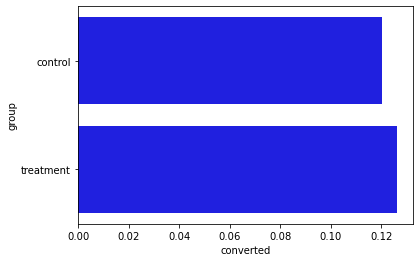

In [13]:
sns.barplot(x= abteste['converted'], y= abteste['group'], ci= False, color= 'blue')

#### O cálculo da primeira estatística básica sobre os processos de conversão de vendas para os dois grupos, resultou em margens bastante próximas entre o grupo controle (12%) e tratamento (12.6%). Para relembrar, o grupo de controle são aqueles agentes que estão acessando o site antigo da organização e o grupo de tratamento acessam o site com novo *design*, consequentemente, espera-se resultado superior de conversões para o segundo grupo devido aos investimentos realizados pela organização no desenvolvimento do novo modelo de site. Contudo, o quadro e gráfico de barras acima apresentam resultados semelhantes.
#### Outro destaque importante de ser levantado no momento, ocorre sobre os resultados alcançados na análise dos dados de controle (12%) em relação ao resultado passado previamente no início do exercício (11%), indicando que existem diferenças na média de conversão entre a amostra de dados selecionado e a população (amostra total da base de dados). Com esse contexto em mente, agora é necessário avançar na análise dos resultados para conseguir aceitar ou rejeitar que o resultado proveniente do grupo de tratamento (12.6%) é estatisticamente significante e, também, se o seu resultado está de acordo com o esperado dado o investimento na nova página.

In [14]:
resultado_controle = abteste[abteste['group'] == 'control'] ['converted']
resultado_tratamento = abteste[abteste['group'] == 'treatment'] ['converted']

controle_n = resultado_controle.count()
tratamento_n = resultado_tratamento.count()
sucesso = [resultado_controle.sum(), resultado_tratamento.sum()]
teste = [controle_n, tratamento_n]

estatistica_z, pval = proportions_ztest(sucesso, nobs= teste)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(sucesso, nobs= teste, alpha= 0.05)

print(f'estatística z: {estatistica_z:.2f}')
print(f'p-valor: {pval:.3f}')

print(f'intervalo de confiança de 95% para o grupo de controle: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'intervalo de confiança de 95% para o grupo de tratamento: [{lower_treat:.3f}, {upper_treat:.3f}]')

estatística z: -0.54
p-valor: 0.587
intervalo de confiança de 95% para o grupo de controle: [0.106, 0.135]
intervalo de confiança de 95% para o grupo de tratamento: [0.111, 0.141]


#### Infelizmente os resultados do teste a/b para decidir se o novo *design* do site auxilia nas conversões de vendas não foram positivos. Com a comparação do resultado do p-valor -> 0.583 em relação ao valor do alpha -> 0.05, definido no início deste trabalho, não é possível rejeitar a hipótese nula de que o novo e antigo site possuem o mesmo resultado (H0: p = p0). De outro modo, com esse resultado significa que o investimento no novo *design* não teve uma performance superior ao antigo em termos estatísticos, isto é, seus resultados não são diferentes.
#### Caso o p-valor indicasse a diferença estatística entre as duas hipóteses, o intervalo de confiança do grupo de tratamento (0.111, 0.141 ou 11.1%, 14.1%), teria captado o resultado almejado pelo investimento no novo site: **aumento de três pontos percentuais na taxa de conversão (11% -> 14%**. Isso porque o resultado está inserido dentro do intervalo de confiança, contudo, o novo *design* não alcançou o resultado aumejado de aumentar as taxas de conversão de vendas sobre os clientes que visitam o site da organização.
#### No início do trabalho foi argumentado que aumentar a base de dados para aplicações de métodos estatísticos de análises acaba por aumentar os custos de aquisição de novas informações por parte da organização. Por outro lado, estritamente em termo estatístico quanto maior for a base amostral, mais confiança se obtém dos resultados alcançados, um processo conhecido como *tradeoff*. Assim, foi definida uma amostra que pudesse ter relevância estatística, sem necessidade de investir elevada quantidade de capital para conseguir uma amostra ainda maior, mas que os resultados da amostra não seriam melhores no sentido de validar que o novo site é melhor que o antigo no quesito conversões. Consequentemente, teria sido um "desperdício" de recursos financeiros ter investido em aquisição de uma base maior de dados e de capital humano (porque os agentes dispendem mais tempo neste modelo).
#### Isso posto, como os resultados não foram de acordo com o objetivo da organização, é necessário que novas rodadas de investimento e utilização do capital da organização seja alocado em novas formas de realizar o objetivo estratégico: **aumentar a taxa de conversão em dois pontos percentuais, de 11% para 14%**.